In [ ]:
# 1. Loading Data 💎
# 2. EDA 📊
# 3. Data Preprocessing ⚙️
# 3.1 Cleaning the corpus 🛠
# 3.2 Stemming 🛠
# 3.3 All together 🛠
# 3.4 Target encoding 🛠
# 4. Tokens visualization 📊
# 5. Vectorization
# 5.1 Tunning CountVectorizer
# 5.2 TF-IDF
# 5.3 Word Embeddings: GloVe
# 6. Modeling
# 6.1 Naive Bayes DTM
# 6.2 Naive Bayes TF-IDF
# 6.3 XGBoost
# 7. LSTM
# 8. BERT
# 9. NLP: Disaster tweets
# 9.1 EDA
# 9.2 Data preprocessing
# 9.3 WordCloud
# 9.4 Modeling
# 9.5 GloVe - LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Loading Data
# Defining all our palette colours.

import plotly_express as px
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [ ]:
max(df['message_len'])

171

In [ ]:
#2. EDA
#Now we are going to take a look about the target distribution and the messages length.
# Balanced Dataset: — Let’s take a simple example if in our data set we have positive values which are approximately same as negative values. Then we can say our dataset in balance.
# Consider Orange color as a positive values and Blue color as a Negative value. We can say that the number of positive values and negative values in approximately same.
# Imbalanced Dataset: — If there is the very high different between the positive values and negative values. Then we can say our dataset in Imbalance Dataset.
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts


array([4825,  747])

In [ ]:
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [ ]:
#As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study later. Anyway, it doesn't seem to be necessary.


In [ ]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()


In [ ]:
#As we can see, the ham message length tend to be lower than spam message length.

In [ ]:
#3. Data Pre-processing
# Now we are going to engineering the data to make it easier for the model to clasiffy.

# This section is very important to reduce the dimensions of the problem.

In [ ]:
#3.1 Cleaning the corpus

In [ ]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


In [ ]:
#3.2 Stemming 🛠

In [ ]:
# Stemming/ Lematization¶
# For grammatical reasons, documents are going to use different forms of a word, such as write, writing and writes. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

# Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

# Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

# As far as the meaning of the words is not important for this study, we will focus on stemming rather than lemmatization.

# Stemming algorithms
# There are several stemming algorithms implemented in NLTK Python library:

# PorterStemmer uses Suffix Stripping to produce stems. PorterStemmer is known for its simplicity and speed. Notice how the PorterStemmer is giving the root (stem) of the word "cats" by simply removing the 's' after cat. This is a suffix added to cat to make it plural. But if you look at 'trouble', 'troubling' and 'troubled' they are stemmed to 'trouble' because PorterStemmer algorithm does not follow linguistics rather a set of 05 rules for different cases that are applied in phases (step by step) to generate stems. This is the reason why PorterStemmer does not often generate stems that are actual English words. It does not keep a lookup table for actual stems of the word but applies algorithmic rules to generate stems. It uses the rules to decide whether it is wise to strip a suffix.
# One can generate its own set of rules for any language that is why Python nltk introduced SnowballStemmers that are used to create non-English Stemmers!
# LancasterStemmer (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix. On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

In [ ]:
import nltk

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazi avail onli in bugi...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri in a wkli comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so earli hor u c alreadi then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goe to usf he live around ...


In [ ]:
#3.3 All together 🛠

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords if you haven't already
nltk.download('stopwords')

# Initialize the stopwords list
stop_words = set(stopwords.words('english'))

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail on bugi n great wo...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,u dun say ear hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


In [ ]:
#3.4 Target encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail on bugi n great wo...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,u dun say ear hor u c alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


In [ ]:
#4. Tokens visualization 📊

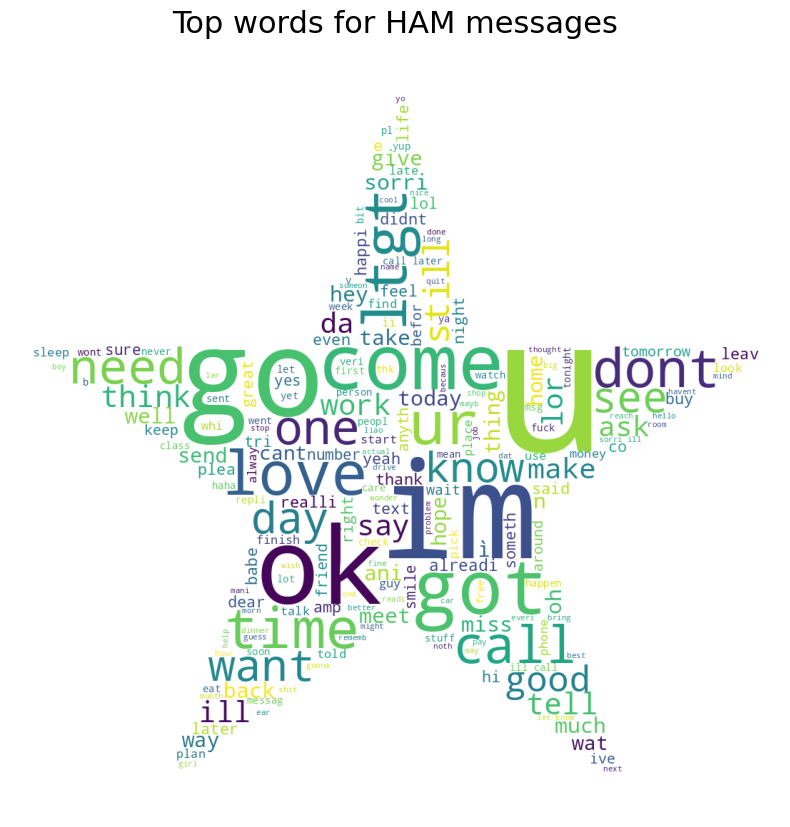

In [ ]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
twitter_mask = np.array(Image.open('/content/drive/MyDrive/archive/star.png'))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


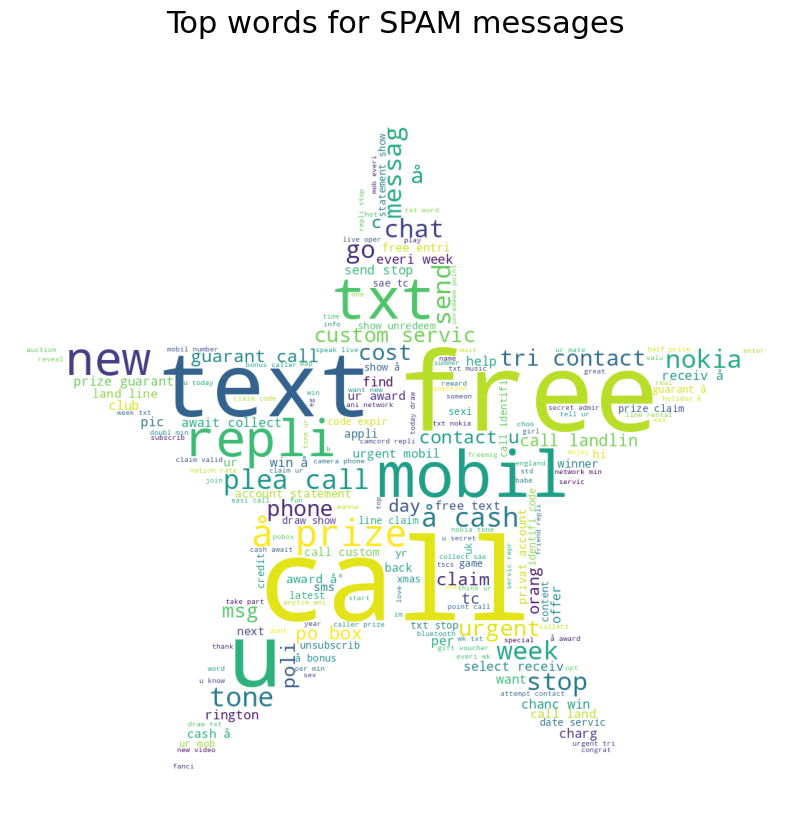

In [ ]:
twitter_mask = np.array(Image.open('/content/drive/MyDrive/archive/star.png'))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
#5. Vectorization

In [ ]:
# Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

# We'll do that in three steps using the bag-of-words model:

# Count how many times does a word occur in each message (Known as term frequency)
# Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
# Normalize the vectors to unit length, to abstract from the original text length (L2 norm)
# Let's begin the first step:

# Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.

# We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

In [ ]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [ ]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [ ]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [ ]:
#5.1 Tunning CountVectorizer

In [ ]:
# CountVectorizer has a few parameters you should know.

# stop_words: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

# ngram_range: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1). In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.

# min_df, max_df: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

# max_features: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else.

# You would set these parameters when initializing your CountVectorizer object as shown below.

In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [ ]:
#5.2 TF-IDF

In [ ]:
# In information retrieval, tf–idf, TF-IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

# tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5693 sparse matrix of type '<class 'numpy.float64'>'
	with 32989 stored elements in Compressed Sparse Row format>

In [ ]:
texts = df['message_clean']
target = df['target_encoded']

In [ ]:
# We need to perform tokenization - the processing of segmenting text into sentences of words. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6737

In [ ]:
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)


array([[1, 2, 3, 4],
       [0, 5, 6, 7],
       [0, 0, 8, 9]], dtype=int32)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

print(train_padded_sentences)



[[   4 3190  283 ...    0    0    0]
 [  10  245  538 ...    0    0    0]
 [  11  367  599 ...    0    0    0]
 ...
 [6735 1014 6736 ...    0    0    0]
 [ 146 1263 1614 ...    0    0    0]
 [1997  389  178 ...    0    0    0]]


In [ ]:
# GloVe¶
# GloVe method is built on an important idea,

# You can derive semantic relationships between words from the co-occurrence matrix.

# To obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

# Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.

# Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/drive/MyDrive/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [ ]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.031087  ,  0.22155   ,  0.44494   , ..., -0.67097002,
         0.24698   , -0.62001002],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#. Modeling

In [ ]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):

    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True

    return fig

In [ ]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [ ]:
# 6.1 Naive Bayes DTM

# ¶
# In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

# Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

In [ ]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9791816223977028


In [ ]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)


0.9719795105888092

In [ ]:
#6.2 Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])

In [ ]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.95908111988514


In [ ]:
#6.3 XGBoost

In [ ]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [ ]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Train: 0.983249581239531
Test: 0.9655419956927495


In [ ]:
#7. LSTM

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional,GlobalMaxPool1D, BatchNormalization, Dropout
def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 81, 100)           673700    
                                                                 
 bidirectional_3 (Bidirecti  (None, 81, 162)           117936    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 162)               0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_1 (Bat  (None, 162)               648       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 162)               0         
                                                      

In [ ]:
# Load the model and train!!
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8849
Epoch 1: val_loss improved from inf to 0.33547, saving model to model.h5
131/131 [==============================] - 41s 254ms/step - loss: 0.3001 - accuracy: 0.8849 - val_loss: 0.3355 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



131/131 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9428
Epoch 2: val_loss improved from 0.33547 to 0.13279, saving model to model.h5
131/131 [==============================] - 33s 256ms/step - loss: 0.1630 - accuracy: 0.9428 - val_loss: 0.1328 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 3/7
131/131 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9608
Epoch 3: val_loss improved from 0.13279 to 0.12456, saving model to model.h5
131/131 [==============================] - 32s 242ms/step - loss: 0.1365 - accuracy: 0.9608 - val_loss: 0.1246 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 4/7
131/131 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9677
Epoch 4: val_loss improved from 0.12456 to 0.07370, saving model to model.h5
131/131 [==============================] - 32s 247ms/step - loss: 0.1111 - accuracy: 0.9677 - val_loss: 0.0737 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 5/7
131/131 [==============================] - 

In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

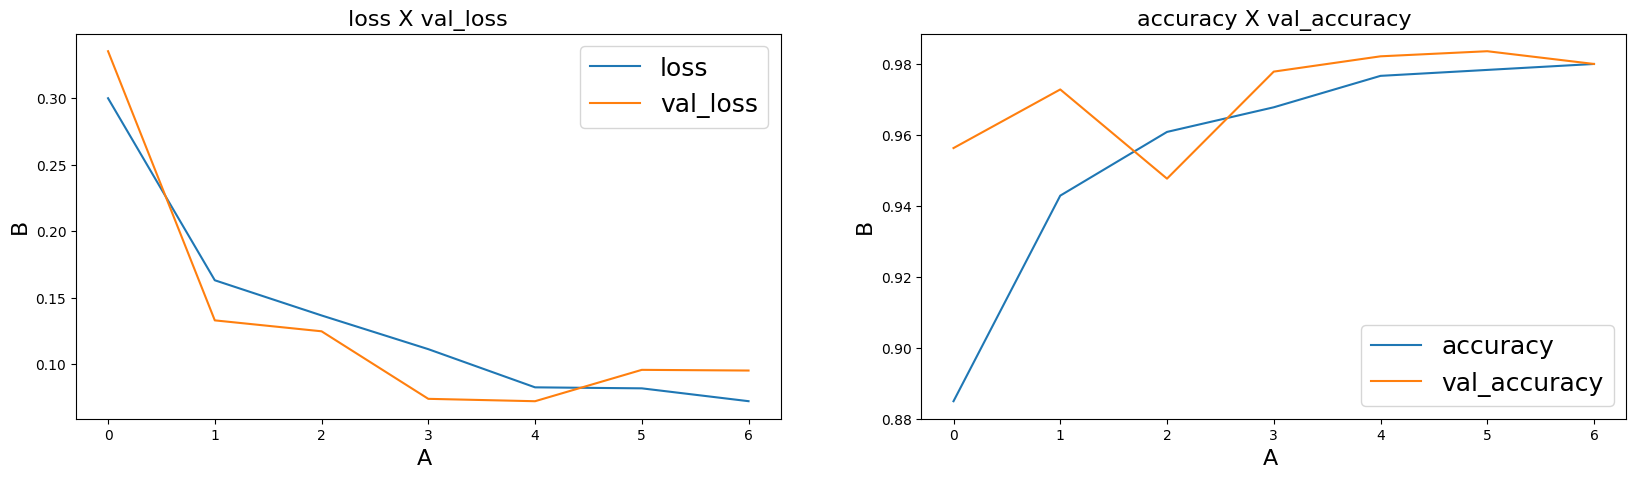

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

44/44 [==============================] - 6s 102ms/step
